In [4]:
import csv
import pickle
import os
import codecs

import numpy as np

from urllib.request import urlopen

import matplotlib.pyplot as plt


class TravelingSalesmanProblem:
    """This class encapsulates the Traveling Salesman Problem.
    City coordinates are read from an online file and distance matrix is calculated.
    The data is serialized to disk.
    The total distance can be calculated for a path represented by a list of city indices.
    A plot can be created for a path represented by a list of city indices.
    :param name: The name of the corresponding TSPLIB problem, e.g. 'burma14' or 'bayg29'.
    """

    def __init__(self, name):
        """
        Creates an instance of a TSP
        :param name: name of the TSP problem
        """

        # initialize instance variables:
        self.name = name
        self.locations = []
        self.distances = []
        self.tspSize = 0

        # initialize the data:
        self.__initData()

    def __len__(self):
        """
        returns the length of the underlying TSP
        :return: the length of the underlying TSP (number of cities)
        """
        return self.tspSize

    def __initData(self):
        """Reads the serialized data, and if not available - calls __create_data() to prepare it
        """

        # attempt to read serialized data:
        try:
            self.locations = pickle.load(open(os.path.join("tsp-data", self.name + "-loc.pickle"), "rb"))
            self.distances = pickle.load(open(os.path.join("tsp-data", self.name + "-dist.pickle"), "rb"))
        except (OSError, IOError):
            pass

        # serailized data not found - create the data from scratch:
        if not self.locations or not self.distances:
            self.__createData()

        # set the problem 'size':
        self.tspSize = len(self.locations)

    def __createData(self):
        """Reads the desired TSP file from the Internet, extracts the city coordinates, calculates the distances
        between every two cities and uses them to populate a distance matrix (two-dimensional array).
        It then serializes the city locations and the calculated distances to disk using the pickle utility.
        """
        self.locations = []

        # open whitespace-delimited file from url and read lines from it:
        with urlopen("http://elib.zib.de/pub/mp-testdata/tsp/tsplib/tsp/" + self.name + ".tsp") as f:
            reader = csv.reader(codecs.iterdecode(f, 'utf-8'), delimiter=" ", skipinitialspace=True)

            # skip lines until one of these lines is found:
            for row in reader:
                if row[0] in ('DISPLAY_DATA_SECTION', 'NODE_COORD_SECTION'):
                    break

            # read data lines until 'EOF' found:
            for row in reader:
                if row[0] != 'EOF':
                    # remove index at beginning of line:
                    del row[0]

                    # convert x,y coordinates to ndarray:
                    self.locations.append(np.asarray(row, dtype=np.float32))
                else:
                    break

            # set the problem 'size':
            self.tspSize = len(self.locations)

            # print data:
            print("length = {}, locations = {}".format(self.tspSize, self.locations))

            # initialize distance matrix by filling it with 0's:
            self.distances = [[0] * self.tspSize for _ in range(self.tspSize)]

            # populate the distance matrix with calculated distances:
            for i in range(self.tspSize):
                for j in range(i + 1, self.tspSize):
                    # calculate euclidean distance between two ndarrays:
                    distance = np.linalg.norm(self.locations[j] - self.locations[i])
                    self.distances[i][j] = distance
                    self.distances[j][i] = distance
                    print("{}, {}: location1 = {}, location2 = {} => distance = {}".format(i, j, self.locations[i], self.locations[j], distance))

            # serialize locations and distances:
            if not os.path.exists("tsp-data"):
                os.makedirs("tsp-data")
            pickle.dump(self.locations, open(os.path.join("tsp-data", self.name + "-loc.pickle"), "wb"))
            pickle.dump(self.distances, open(os.path.join("tsp-data", self.name + "-dist.pickle"), "wb"))

    def getTotalDistance(self, indices):
        """Calculates the total distance of the path described by the given indices of the cities
        :param indices: A list of ordered city indices describing the given path.
        :return: total distance of the path described by the given indices
        """
        # distance between th elast and first city:
        distance = self.distances[indices[-1]][indices[0]]

        # add the distance between each pair of consequtive cities:
        for i in range(len(indices) - 1):
            distance += self.distances[indices[i]][indices[i + 1]]

        return distance

    def plotData(self, indices):
        """plots the path described by the given indices of the cities
        :param indices: A list of ordered city indices describing the given path.
        :return: the resulting plot
        """

        # plot the dots representing the cities:
        plt.scatter(*zip(*self.locations), marker='.', color='red')

        # create a list of the corresponding city locations:
        locs = [self.locations[i] for i in indices]
        locs.append(locs[0])

        # plot a line between each pair of consequtive cities:
        plt.plot(*zip(*locs), linestyle='-', color='blue')

        return plt

random solution =  [20, 3, 0, 23, 8, 7, 25, 4, 29, 21, 17, 2, 18, 13, 1, 28, 16, 22, 30, 26, 9, 15, 11, 12, 5, 6, 27, 24, 10, 14, 19]
route breakdown =  [[20, 3, 0, 23, 8, 7, 25, 4], [21, 17, 2, 18, 13, 1, 28, 16, 22], [26, 9, 15, 11, 5, 6, 27, 24, 10, 14, 19]]
max distance =  10125.11


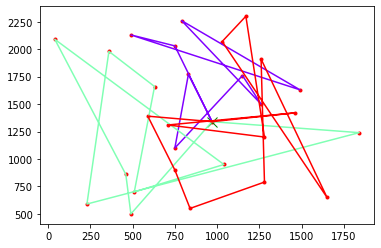

In [5]:
import random

import numpy as np
import matplotlib.pyplot as plt



class VehicleRoutingProblem:

    def __init__(self, tspName, numOfVehicles, depotIndex):
        """
        Creates an instance of a VRP
        :param tspName: name of the underlying TSP
        :param numOfVehicles: number of vehicles used
        :param depotIndex: the index of the TSP city that will be used as the depot location
        """
        self.tsp = TravelingSalesmanProblem(tspName)
        self.numOfVehicles = numOfVehicles
        self.depotIndex = depotIndex

    def __len__(self):
        """
        returns the number of indices used to internally represent the VRP
        :return: the number of indices used to internally represent the VRP
        """
        return len(self.tsp) + self.numOfVehicles - 1

    def getRoutes(self, indices):
        """
        breaks the list of given indices into separate routes,
        by detecting the 'separator' indices
        :param indices: list of indices, including 'separator' indices
        :return: a list of routes, each route being a list of location indices from the tsp problem
        """

        # initialize lists:
        routes = []
        route = []

        # loop over all indices in the list:
        for i in indices:

            # skip depot index:
            if i == self.depotIndex:
                continue

            # index is part of the current route:
            if not self.isSeparatorIndex(i):
                route.append(i)

            # separator index - route is complete:
            else:
                routes.append(route)
                route = []  # reset route

        # append the last route:
        if route or self.isSeparatorIndex(i):
            routes.append(route)

        return routes

    def isSeparatorIndex(self, index):
        """
        Finds if curent index is a separator index
        :param index: denotes the index of the location
        :return: True if the given index is a separator
        """
        # check if the index is larger than the number of the participating locations:
        return index >= len(self) - (self.numOfVehicles - 1)

    def getRouteDistance(self, indices):
        """Calculates total the distance of the path that starts at the depo location and goes through
        the cities described by the given indices
        :param indices: a list of ordered city indices describing the given path.
        :return: total distance of the path described by the given indices
        """
        if not indices:
            return 0

        # find the distance between the depo location and the city:
        distance = self.tsp.distances[self.depotIndex][indices[0]]

        # add the distance between the last city and the depot location:
        distance += self.tsp.distances[indices[-1]][self.depotIndex]

        # add the distances between the cities along the route:
        for i in range(len(indices) - 1):
            distance += self.tsp.distances[indices[i]][indices[i + 1]]
        return distance

    def getTotalDistance(self, indices):
        """Calculates the combined distance of the various paths described by the given indices
        :param indices: a list of ordered city indices and separator indices describing one or more paths.
        :return: combined distance of the various paths described by the given indices
        """
        totalDistance = 0
        for route in self.getRoutes(indices):
            routeDistance = self.getRouteDistance(route)
            #print("- route distance = ", routeDistance)
            totalDistance += routeDistance
        return totalDistance

    def getMaxDistance(self, indices):
        """Calculates the max distance among the distances of the various paths described by the given indices
        :param indices: a list of ordered city indices and separator indices describing one or more paths.
        :return: max distance among the distances of the various paths described by the given indices
        """
        maxDistance = 0
        for route in self.getRoutes(indices):
            routeDistance = self.getRouteDistance(route)
            #print("- route distance = ", routeDistance)
            maxDistance = max(routeDistance, maxDistance)
        return maxDistance

    def getAvgDistance(self, indices):
        """Calculates the average distance among the distances of the various paths described by the given indices
        Does not consider empty paths
        :param indices: a list of ordered city indices and separator indices describing one or more paths.
        :return: max distance among the distances of the various paths described by the given indices
        """

        routes = self.getRoutes(indices)
        totalDistance = 0
        counter = 0
        for route in routes:
            if route:  # consider only routes that are not empty
                routeDistance = self.getRouteDistance(route)
                # print("- route distance = ", routeDistance)
                totalDistance += routeDistance
                counter += 1
        return totalDistance/counter

    def plotData(self, indices):
        """breaks the list of indices into separate routes and plot each route in a different color
        :param indices: A list of ordered indices describing the combined routes
        :return: the resulting plot
        """

        # plot th ecities of the underlying TSP:
        plt.scatter(*zip(*self.tsp.locations), marker='.', color='red')

        # mark the depot location with a large 'X':
        d = self.tsp.locations[self.depotIndex]
        plt.plot(d[0], d[1], marker='x', markersize=10, color='green')

        # break the indices to separate routes and plot each route in a different color:
        routes = self.getRoutes(indices)
        color = iter(plt.cm.rainbow(np.linspace(0, 1, self.numOfVehicles)))
        for route in routes:
            route = [self.depotIndex] + route + [self.depotIndex]
            stops = [self.tsp.locations[i] for i in route]
            plt.plot(*zip(*stops), linestyle='-', color=next(color))

        return plt


def main():
    # create a problem instance:
    vrp = VehicleRoutingProblem("bayg29", 3, 12)

    # generate random solution and evaluate it:
    randomSolution = random.sample(range(len(vrp)), len(vrp))
    print("random solution = ", randomSolution)
    print("route breakdown = ", vrp.getRoutes(randomSolution))
    print("max distance = ", vrp.getMaxDistance(randomSolution))

    # plot the solution:
    plot = vrp.plotData(randomSolution)
    plot.show()


if __name__ == "__main__":
    main()

In [1]:
from deap import tools
from deap import algorithms

def eaSimpleWithElitism(population, toolbox, cxpb, mutpb, ngen, stats=None,
             halloffame=None, verbose=__debug__):
    """This algorithm is similar to DEAP eaSimple() algorithm, with the modification that
    halloffame is used to implement an elitism mechanism. The individuals contained in the
    halloffame are directly injected into the next generation and are not subject to the
    genetic operators of selection, crossover and mutation.
    """
    logbook = tools.Logbook()
    logbook.header = ['gen', 'nevals'] + (stats.fields if stats else [])

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    if halloffame is None:
        raise ValueError("halloffame parameter must not be empty!")

    halloffame.update(population)
    hof_size = len(halloffame.items) if halloffame.items else 0

    record = stats.compile(population) if stats else {}
    logbook.record(gen=0, nevals=len(invalid_ind), **record)
    if verbose:
        print(logbook.stream)

    # Begin the generational process
    for gen in range(1, ngen + 1):

        # Select the next generation individuals
        offspring = toolbox.select(population, len(population) - hof_size)

        # Vary the pool of individuals
        offspring = algorithms.varAnd(offspring, toolbox, cxpb, mutpb)

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # add the best back to population:
        offspring.extend(halloffame.items)

        # Update the hall of fame with the generated individuals
        halloffame.update(offspring)

        # Replace the current population by the offspring
        population[:] = offspring

        # Append the current generation statistics to the logbook
        record = stats.compile(population) if stats else {}
        logbook.record(gen=gen, nevals=len(invalid_ind), **record)
        if verbose:
            print(logbook.stream)

    return population, logbook

# eaSimple

gen	nevals	min    	avg    
0  	500   	8732.15	16903.6
1  	452   	7887.46	15022.4
2  	463   	7932.5 	13727.4
3  	459   	8143.51	12980.1
4  	463   	7586.96	12416.3
5  	454   	8193.71	11867.3
6  	470   	7891.65	11444.4
7  	463   	7891.65	11481.2
8  	462   	7891.65	11051.1
9  	458   	7859.75	10803.2
10 	463   	7543.08	10432.9
11 	471   	7630.6 	10503.9
12 	470   	7630.6 	10220.1
13 	449   	7217.76	10221.8
14 	462   	7172.31	9971.85
15 	473   	7172.31	10096.7
16 	462   	7172.31	9862.43
17 	456   	7213.03	9682.13
18 	455   	6919.27	9584.65
19 	468   	7198.34	9667.88
20 	445   	7105.33	9379.2 
21 	462   	6986.98	9292.07
22 	464   	6986.98	9252.96
23 	451   	6961.88	9197.4 
24 	462   	6961.88	9157.71
25 	440   	7005.82	9089.45
26 	466   	6724.6 	8962.64
27 	450   	7081.66	9069.04
28 	461   	7082.43	8882.46
29 	458   	7005.82	8842.42
30 	445   	6963.93	8585.38
31 	480   	7005.82	8681.46
32 	457   	6885.47	8575.2 
33 	451   	6934.19	8666.79
34 	452   	6821.55	8570.14
35 	473   	6809.54	8470.69
3

305	456   	4287.24	4610.52
306	458   	4287.24	4569.48
307	461   	4287.24	4651.01
308	466   	4287.24	4608.79
309	471   	4287.24	4734.03
310	441   	4287.24	4629.04
311	457   	4287.24	4590.15
312	471   	4287.24	4645.44
313	456   	4287.24	4579.5 
314	461   	4287.24	4588.71
315	456   	4287.24	4586.04
316	461   	4287.24	4727.8 
317	461   	4287.24	4603.05
318	463   	4287.24	4567.65
319	460   	4287.24	4558.31
320	469   	4287.24	4611.6 
321	454   	4287.24	4540.23
322	457   	4287.24	4620.36
323	467   	4287.24	4668.84
324	458   	4287.24	4642.75
325	451   	4287.24	4567.04
326	469   	4287.24	4619.93
327	453   	4287.24	4567.81
328	457   	4287.24	4549.84
329	458   	4287.24	4642.09
330	459   	4287.24	4642.57
331	452   	4287.24	4620.82
332	460   	4287.24	4660.26
333	460   	4287.24	4633.57
334	463   	4287.24	4555.84
335	470   	4287.24	4584.16
336	467   	4287.24	4542.79
337	461   	4287.24	4541.63
338	448   	4287.24	4554.74
339	456   	4287.24	4588.61
340	462   	4287.24	4567.58
341	455   	4287.24	4661.89
3

611	455   	4287.24	4743.12
612	465   	4287.24	4621.96
613	458   	4287.24	4687.9 
614	462   	4287.24	4639.31
615	470   	4287.24	4582.57
616	476   	4287.24	4551.91
617	474   	4287.24	4653.86
618	447   	4287.24	4546.12
619	460   	4287.24	4639.61
620	443   	4287.24	4622.12
621	461   	4287.24	4698.41
622	468   	4287.24	4656.62
623	453   	4287.24	4614.95
624	452   	4287.24	4568.34
625	463   	4287.24	4577.38
626	468   	4287.24	4570.96
627	476   	4287.24	4542.39
628	466   	4287.24	4526.83
629	471   	4287.24	4633.08
630	459   	4287.24	4588.09
631	461   	4287.24	4628.57
632	463   	4287.24	4612.56
633	447   	4287.24	4581.96
634	471   	4287.24	4687.36
635	457   	4287.24	4557.48
636	466   	4287.24	4608.51
637	458   	4287.24	4551.16
638	460   	4287.24	4564.87
639	463   	4287.24	4675.83
640	464   	4287.24	4615.04
641	467   	4287.24	4695.54
642	451   	4287.24	4633.62
643	462   	4287.24	4614.37
644	468   	4287.24	4614.23
645	459   	4287.24	4595.19
646	463   	4287.24	4631.76
647	468   	4287.24	4603.97
6

919	469   	4287.24	4603.03
920	460   	4287.24	4609.71
921	451   	4287.24	4568.59
922	457   	4287.24	4558.09
923	443   	4287.24	4618.57
924	468   	4287.24	4692.29
925	473   	4287.24	4676.75
926	473   	4287.24	4569.98
927	464   	4287.24	4603.44
928	470   	4287.24	4612.8 
929	463   	4287.24	4631.51
930	452   	4287.24	4624.75
931	459   	4287.24	4583.31
932	469   	4287.24	4608.7 
933	453   	4287.24	4559.72
934	466   	4287.24	4589.33
935	467   	4287.24	4591.62
936	461   	4287.24	4579.56
937	463   	4287.24	4594.13
938	470   	4287.24	4668.88
939	444   	4287.24	4575.32
940	464   	4287.24	4621.34
941	457   	4287.24	4634.98
942	463   	4287.24	4626.11
943	447   	4287.24	4587.15
944	456   	4287.24	4618.36
945	463   	4287.24	4542.01
946	467   	4287.24	4597.06
947	458   	4287.24	4598.17
948	463   	4287.24	4603.7 
949	454   	4287.24	4613.19
950	458   	4287.24	4582.28
951	471   	4287.24	4598.96
952	452   	4287.24	4599.99
953	477   	4287.24	4521.69
954	465   	4287.24	4627.22
955	460   	4287.24	4576.89
9

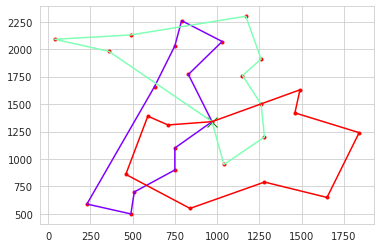

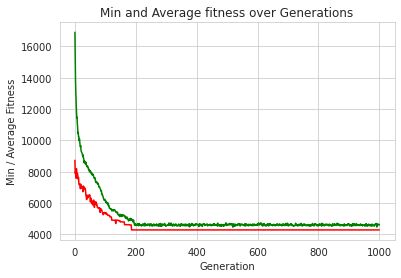

In [9]:
from deap import base
from deap import creator
from deap import tools

import random
import array

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


#import elitism

# set the random seed:
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

# create the desired vehicle routing problem using a traveling salesman problem instance:
TSP_NAME = "bayg29"
NUM_OF_VEHICLES = 3
DEPOT_LOCATION = 12
vrp = VehicleRoutingProblem(TSP_NAME, NUM_OF_VEHICLES, DEPOT_LOCATION)

# Genetic Algorithm constants:
POPULATION_SIZE = 500
P_CROSSOVER = 0.9  # probability for crossover
P_MUTATION = 0.2   # probability for mutating an individual
MAX_GENERATIONS = 1000
HALL_OF_FAME_SIZE = 30

toolbox = base.Toolbox()

# define a single objective, minimizing fitness strategy:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))

# create the Individual class based on list of integers:
creator.create("Individual", array.array, typecode='i', fitness=creator.FitnessMin)

# create an operator that generates randomly shuffled indices:
toolbox.register("randomOrder", random.sample, range(len(vrp)), len(vrp))

# create the individual creation operator to fill up an Individual instance with shuffled indices:
toolbox.register("individualCreator", tools.initIterate, creator.Individual, toolbox.randomOrder)

# create the population creation operator to generate a list of individuals:
toolbox.register("populationCreator", tools.initRepeat, list, toolbox.individualCreator)


# fitness calculation - compute the max distance that the vehicles covered
# for the given list of cities represented by indices:
def vrpDistance(individual):
    return vrp.getMaxDistance(individual),  # return a tuple


toolbox.register("evaluate", vrpDistance)

# Genetic operators:
toolbox.register("select", tools.selTournament, tournsize=2)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=1.0/len(vrp))
toolbox.register("mate", tools.cxUniformPartialyMatched, indpb=2.0/len(vrp))


# Genetic Algorithm flow:
def main():

    # create initial population (generation 0):
    population = toolbox.populationCreator(n=POPULATION_SIZE)

    # prepare the statistics object:
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min)
    stats.register("avg", np.mean)

    # define the hall-of-fame object:
    hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

    # perform the Genetic Algorithm flow with hof feature added:
    population, logbook = algorithms.eaSimple(population, toolbox, cxpb=P_CROSSOVER, mutpb=P_MUTATION,
                                              ngen=MAX_GENERATIONS, stats=stats, halloffame=hof, verbose=True)

    # print best individual info:
    best = hof.items[0]
    print("-- Best Ever Individual = ", best)
    print("-- Best Ever Fitness = ", best.fitness.values[0])

    print("-- Route Breakdown = ", vrp.getRoutes(best))
    print("-- total distance = ", vrp.getTotalDistance(best))
    print("-- max distance = ", vrp.getMaxDistance(best))

    # plot best solution:
    plt.figure(1)
    vrp.plotData(best)

    # plot statistics:
    minFitnessValues, meanFitnessValues = logbook.select("min", "avg")
    plt.figure(2)
    sns.set_style("whitegrid")
    plt.plot(minFitnessValues, color='red')
    plt.plot(meanFitnessValues, color='green')
    plt.xlabel('Generation')
    plt.ylabel('Min / Average Fitness')
    plt.title('Min and Average fitness over Generations')

    # show both plots:
    plt.show()


if __name__ == "__main__":
    main()

# eaSimpleWithElitism


gen	nevals	min    	avg  
0  	500   	8688.72	16622
1  	426   	8441.91	14533.5
2  	424   	8441.91	13146.7
3  	429   	8168.37	12264.1
4  	442   	8168.37	11725.5
5  	428   	7984.16	11048.3
6  	426   	7643.62	10839.2
7  	445   	7485.81	10400.7
8  	425   	7444.85	10350.3
9  	431   	6904.97	9908.5 
10 	417   	6904.97	9844.87
11 	440   	6904.97	9671.5 
12 	430   	6904.97	9702.22
13 	452   	6904.97	9835.68
14 	448   	6904.97	9463.5 
15 	430   	6904.97	9326.52
16 	444   	6686.05	9370.04
17 	444   	6651.8 	9260.8 
18 	438   	6651.8 	9404.15
19 	442   	6651.8 	9150.5 
20 	442   	6435.87	8995.77
21 	429   	6435.87	8576.94
22 	437   	6435.87	8385.47
23 	445   	6435.87	8272.9 
24 	423   	6372.01	8000.36
25 	420   	6219.81	7992.72
26 	428   	6197.79	7722.75
27 	447   	6161.85	7531.67
28 	426   	6143.4 	7404.46
29 	434   	5901.08	7023.46
30 	428   	5901.08	6870.37
31 	440   	5901.08	6740.82
32 	427   	5901.08	6673.01
33 	440   	5797.05	6641.26
34 	422   	5797.05	6576.96
35 	425   	5797.05	6522.48
36 	4

308	417   	4701.76	4930.34
309	438   	4701.76	4961.27
310	440   	4701.76	5026.18
311	437   	4701.76	4953.34
312	427   	4701.76	4973.98
313	415   	4701.76	4928.92
314	436   	4701.76	4963.34
315	416   	4701.76	4948.18
316	425   	4701.76	4949.76
317	433   	4701.76	4934.47
318	436   	4701.76	4964.36
319	439   	4701.76	5007.86
320	441   	4701.76	4929.76
321	432   	4701.76	4939.88
322	417   	4701.76	4975.44
323	418   	4701.76	4965.92
324	437   	4701.76	4952.22
325	441   	4701.76	4979.31
326	441   	4701.76	4963.32
327	435   	4701.76	5035.63
328	432   	4701.76	4991.36
329	447   	4701.76	5014.87
330	440   	4701.76	4986.65
331	432   	4701.76	4874.6 
332	429   	4701.76	4988.96
333	423   	4701.76	5028.99
334	424   	4701.76	5027.98
335	427   	4701.76	5016.13
336	434   	4701.76	5057.18
337	431   	4701.76	5032.13
338	437   	4701.76	5008.79
339	426   	4701.76	5083.62
340	426   	4701.76	4957.6 
341	434   	4701.76	4947.45
342	423   	4701.76	4959.82
343	441   	4701.76	4947.11
344	431   	4701.76	4948.71
3

614	433   	4274.77	4799.5 
615	425   	4273.45	4776.7 
616	434   	4273.45	4693.74
617	428   	4273.45	4634.66
618	444   	4273.45	4634.47
619	434   	4273.45	4639.46
620	435   	4255.27	4625.84
621	437   	4255.27	4585.44
622	421   	4255.27	4581.93
623	436   	4255.27	4575.03
624	427   	4255.27	4564.52
625	434   	4255.27	4523.82
626	439   	4244.4 	4532.3 
627	432   	4244.4 	4545.46
628	441   	4244.4 	4578.28
629	426   	4244.4 	4532.5 
630	426   	4231.05	4548.64
631	417   	4231.05	4573.47
632	442   	4231.05	4524.13
633	436   	4231.05	4530.9 
634	416   	4231.05	4629.73
635	443   	4231.05	4616.37
636	447   	4231.05	4584.92
637	421   	4231.05	4569.94
638	422   	4231.05	4537.88
639	426   	4231.05	4513.12
640	413   	4229.62	4542.49
641	449   	4229.62	4588.16
642	433   	4229.62	4583.96
643	411   	4229.62	4488.31
644	438   	4229.62	4507.92
645	433   	4229.62	4528.33
646	439   	4229.62	4545.32
647	429   	4229.62	4519.74
648	421   	4229.62	4484.62
649	433   	4229.62	4600.39
650	415   	4229.62	4486.35
6

918	429   	4070.57	4394.46
919	425   	4070.57	4335.65
920	421   	4070.57	4390.47
921	435   	4070.57	4443.46
922	440   	4070.57	4355.02
923	420   	4070.57	4313.21
924	413   	4070.57	4350.37
925	439   	4070.57	4307.29
926	433   	4070.57	4350.18
927	432   	4070.57	4383.28
928	431   	4070.57	4424.12
929	433   	4070.57	4382.66
930	426   	4070.57	4333.16
931	430   	4070.57	4418.57
932	427   	4070.57	4371.45
933	427   	4070.57	4323.58
934	426   	4070.57	4352.19
935	427   	4070.57	4284.47
936	446   	4070.57	4299.07
937	442   	4070.57	4393.19
938	431   	4070.57	4343.74
939	433   	4070.57	4336.65
940	435   	4070.57	4371.8 
941	445   	4070.57	4287.33
942	411   	4070.57	4301.05
943	421   	4070.57	4325.17
944	421   	4070.57	4354.61
945	425   	4070.57	4374.49
946	430   	4070.57	4401.95
947	447   	4070.57	4425.34
948	431   	4070.57	4372.77
949	436   	4070.57	4371.7 
950	441   	4070.57	4344.64
951	428   	4070.57	4478.63
952	434   	4070.57	4422.43
953	446   	4070.57	4344.8 
954	427   	4070.57	4382.76
9

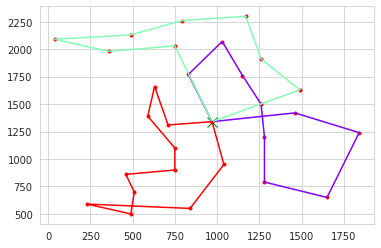

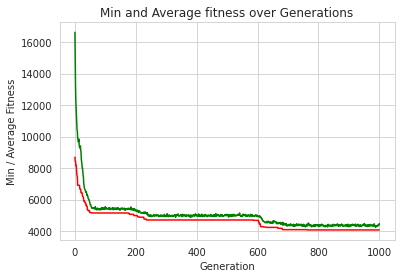

In [16]:

def main_1():

    # create initial population (generation 0):
    population = toolbox.populationCreator(n=POPULATION_SIZE)

    # prepare the statistics object:
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min)
    stats.register("avg", np.mean)

    # define the hall-of-fame object:
    hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

    # perform the Genetic Algorithm flow with hof feature added:
    population, logbook = eaSimpleWithElitism(population, toolbox, cxpb=P_CROSSOVER, mutpb=P_MUTATION,
                                              ngen=MAX_GENERATIONS, stats=stats, halloffame=hof, verbose=True)

    # print best individual info:
    best = hof.items[0]
    print("-- Best Ever Individual = ", best)
    print("-- Best Ever Fitness = ", best.fitness.values[0])

    print("-- Route Breakdown = ", vrp.getRoutes(best))
    print("-- total distance = ", vrp.getTotalDistance(best))
    print("-- max distance = ", vrp.getMaxDistance(best))

    # plot best solution:
    plt.figure(1)
    vrp.plotData(best)

    # plot statistics:
    minFitnessValues, meanFitnessValues = logbook.select("min", "avg")
    plt.figure(2)
    sns.set_style("whitegrid")
    plt.plot(minFitnessValues, color='red')
    plt.plot(meanFitnessValues, color='green')
    plt.xlabel('Generation')
    plt.ylabel('Min / Average Fitness')
    plt.title('Min and Average fitness over Generations')

    # show both plots:
    plt.show()


main_1()

# add 3 cars

gen	nevals	min    	avg  
0  	500   	5871.44	11767
1  	434   	5871.44	10236.5
2  	428   	5628.74	9318.53
3  	446   	5209.01	8802.22
4  	421   	5099.05	8244.78
5  	414   	5056.74	8182.88
6  	429   	5056.74	7977.43
7  	452   	5056.74	7907.61
8  	437   	5056.74	7922.54
9  	420   	4910.99	7640.94
10 	426   	4677.58	7498.05
11 	429   	4677.58	7188.7 
12 	447   	4475.1 	7309.78
13 	438   	4475.1 	7087.05
14 	430   	4475.1 	7006.28
15 	438   	4469.88	6682.62
16 	438   	4469.88	6324.62
17 	440   	4455.95	5856.67
18 	422   	4455.95	5467.94
19 	443   	4455.95	5114.55
20 	440   	4263.16	5031.7 
21 	431   	4263.16	4929.59
22 	445   	4263.16	4825.62
23 	435   	4263.16	4847.47
24 	437   	4041.37	4736.48
25 	442   	4041.37	4689.92
26 	432   	4041.37	4778.11
27 	433   	4041.37	4745.8 
28 	432   	4041.37	4666.21
29 	424   	4028.47	4653.78
30 	441   	3978.68	4611.26
31 	434   	3978.68	4590.98
32 	430   	3978.68	4613.5 
33 	440   	3978.68	4602.6 
34 	429   	3978.68	4582.99
35 	433   	3950.96	4656.95
36 	4

303	439   	2575.84	2788.19
304	444   	2575.84	2851.58
305	431   	2575.84	2834.71
306	436   	2575.84	2891.16
307	426   	2575.84	2910.15
308	440   	2575.84	2832.63
309	422   	2575.84	2832.62
310	423   	2575.84	2950.89
311	432   	2575.84	2827.44
312	430   	2575.84	2864.15
313	441   	2575.84	2827.37
314	426   	2575.84	2848.9 
315	434   	2575.84	2863.39
316	412   	2575.84	2813.29
317	423   	2575.84	2820.92
318	430   	2575.84	2865.67
319	449   	2575.84	2801.89
320	434   	2575.84	2848.94
321	443   	2575.84	2812.13
322	441   	2575.84	2805.68
323	430   	2575.84	2847.64
324	438   	2575.84	2803.13
325	429   	2575.84	2815.9 
326	418   	2575.84	2880.78
327	437   	2575.84	2890.74
328	422   	2575.84	2877.43
329	427   	2575.84	2873.33
330	445   	2575.84	2830.32
331	434   	2575.84	2826.77
332	425   	2575.84	2902.18
333	440   	2575.84	2849.26
334	424   	2575.84	2901.55
335	435   	2575.84	2890.34
336	443   	2575.84	2921.12
337	426   	2575.84	2851.98
338	427   	2575.84	2854.94
339	428   	2575.84	2856.25
3

613	426   	2575.84	2806.03
614	427   	2575.84	2817.5 
615	442   	2575.84	2892.26
616	414   	2575.84	2795.27
617	423   	2575.84	2783.91
618	438   	2575.84	2848.95
619	434   	2575.84	2802.75
620	433   	2575.84	2890.05
621	411   	2575.84	2860.25
622	432   	2575.84	2831.52
623	435   	2575.84	2836.41
624	419   	2575.84	2842.43
625	437   	2575.84	2821.35
626	427   	2575.84	2860.27
627	409   	2575.84	2814.85
628	434   	2575.84	2868.62
629	436   	2575.84	2859.95
630	442   	2575.84	2832.2 
631	418   	2575.84	2809.61
632	429   	2575.84	2958.22
633	435   	2575.84	2879.15
634	422   	2575.84	2839.8 
635	422   	2575.84	2840.16
636	437   	2575.84	2807.07
637	430   	2575.84	2822.96
638	442   	2575.84	2931.2 
639	434   	2575.84	2880.86
640	435   	2575.84	2812.54
641	433   	2575.84	2875.24
642	427   	2575.84	2858.18
643	422   	2575.84	2886.17
644	415   	2575.84	2839.08
645	441   	2575.84	2841.29
646	440   	2575.84	2912.9 
647	437   	2575.84	2903.58
648	436   	2575.84	2834.66
649	413   	2575.84	2842.61
6

921	429   	2575.84	2886.24
922	416   	2575.84	2818.91
923	438   	2575.84	2879.5 
924	443   	2575.84	2860.86
925	444   	2575.84	2841.65
926	420   	2575.84	2832.18
927	418   	2575.84	2840.12
928	427   	2575.84	2861.78
929	428   	2575.84	2821.52
930	431   	2575.84	2782.72
931	435   	2575.84	2874.54
932	428   	2575.84	2859.15
933	442   	2575.84	2876.16
934	427   	2575.84	2864.25
935	437   	2575.84	2890.6 
936	433   	2575.84	2754.73
937	425   	2575.84	2818.41
938	441   	2575.84	2866.77
939	436   	2575.84	2824.47
940	431   	2575.84	2836.28
941	424   	2575.84	2910.05
942	436   	2575.84	2875.47
943	426   	2575.84	2891.47
944	433   	2575.84	2938.3 
945	435   	2575.84	2907.78
946	440   	2575.84	2885.14
947	437   	2575.84	2825.78
948	442   	2575.84	2793.63
949	435   	2575.84	2824.5 
950	444   	2575.84	2896.8 
951	423   	2575.84	2823.07
952	437   	2575.84	2855.5 
953	421   	2575.84	2818.29
954	446   	2575.84	2886.39
955	429   	2575.84	2856.01
956	424   	2575.84	2879.71
957	433   	2575.84	2868.79
9

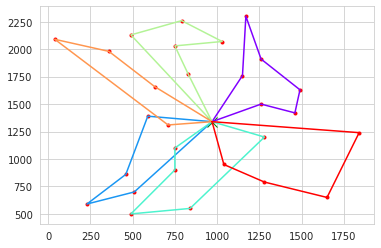

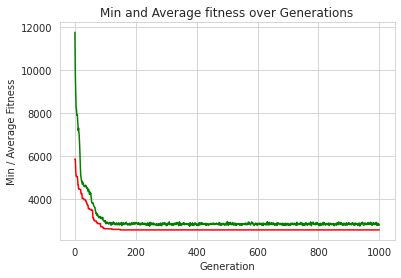

In [18]:
vrp = VehicleRoutingProblem(TSP_NAME, 6, DEPOT_LOCATION)
toolbox = base.Toolbox()

# define a single objective, minimizing fitness strategy:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))

# create the Individual class based on list of integers:
creator.create("Individual", array.array, typecode='i', fitness=creator.FitnessMin)

# create an operator that generates randomly shuffled indices:
toolbox.register("randomOrder", random.sample, range(len(vrp)), len(vrp))

# create the individual creation operator to fill up an Individual instance with shuffled indices:
toolbox.register("individualCreator", tools.initIterate, creator.Individual, toolbox.randomOrder)

# create the population creation operator to generate a list of individuals:
toolbox.register("populationCreator", tools.initRepeat, list, toolbox.individualCreator)


# fitness calculation - compute the max distance that the vehicles covered
# for the given list of cities represented by indices:
def vrpDistance(individual):
    return vrp.getMaxDistance(individual),  # return a tuple


toolbox.register("evaluate", vrpDistance)

# Genetic operators:
toolbox.register("select", tools.selTournament, tournsize=2)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=1.0/len(vrp))
toolbox.register("mate", tools.cxUniformPartialyMatched, indpb=2.0/len(vrp))


main_1()